In [1]:
def extract_HI_oneline(tar_ra, tar_dec, cube_file, beam):
    '''
    tar_ra/tar_dec: the ra/dec for the sightline, in degree
    cubefile: HI4PI or GALFA-HI data file
    beam: the beam size of the corresponding beam,
          should be in unit of degree;
          for HI4PI, beam=16/60.
          for GALFA-HI, beam=4/60.
    '''
    
    from astropy.coordinates import SkyCoord
    import astropy.io.fits as fits 
    import astropy.units as u
    import numpy as np
    from yzGALFAHI.get_cubeinfo import get_cubeinfo ### Harrison, you need to change this line.
    
    # get sky coordinate for the target
    tar_coord = SkyCoord(ra=tar_ra*u.deg, dec=tar_dec*u.deg, frame='icrs')
    print('Sightline: RA=%.2f, DEC=%.2f, l=%.2f, b=%.2f (degree)'%(tar_ra, tar_dec, 
                                                                   tar_coord.galactic.l.degree, 
                                                                   tar_coord.galactic.b.degree))
    print('Extracted within beam size: %.2f arcmin'%(beam*60))
    
    # get sky coordiante for all the coordinates in the cube 
    header = fits.getheader(cube_file)
    cube_ra, cube_dec, cube_vel = get_cubeinfo(header)
    cube_coord = SkyCoord(ra=cube_ra*u.deg, dec=cube_dec*u.deg, frame='icrs')
    print('Cube RA range: [%.2f, %.2f], DEC range: [%.2f, %.2f]'%(cube_ra[0, -1], 
                                                                  cube_ra[0, 0], 
                                                                  cube_dec[0, 0], 
                                                                  cube_dec[-1, 0]))
    
    # calculate the distance between the designated point and the whole cube
    dist_coord = tar_coord.separation(cube_coord)
    dist = dist_coord.degree # distance in degree 
    
    within_beam_2d = dist<=beam/2. # beam should be in unit of degree. 
            
    within_beam_3d = np.asarray([within_beam_2d]*cube_vel.size)

    cube_data = fits.getdata(cube_file)
    cube_data[np.logical_not(within_beam_3d)] = np.nan

    mean_spec = np.nanmean(np.nanmean(cube_data, axis=2), axis=1)
    
    return cube_vel, mean_spec

In [2]:
tar_ra = 8  # deg
tar_dec = 3 # deg
beam = 16.2/60. # deg 
cube_file = '/Users/Yong/Desktop/temp_cubes/CAR_E01.fits'

In [3]:
cube_vel, mean_spec = extract_HI_oneline(tar_ra, tar_dec, cube_file, beam)

Sightline: RA=8.00, DEC=3.00, l=113.33, b=-59.51 (degree)
Extracted within beam size: 16.20 arcmin
Cube RA range: [359.00, 21.08], DEC range: [-11.00, 11.08]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice


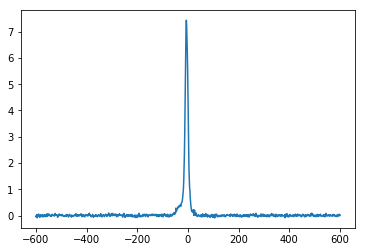

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(cube_vel, mean_spec)

# should do a sanity check with this website: https://www.astro.uni-bonn.de/hisurvey/AllSky_profiles/